In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import scipy.stats as ss
import statsmodels.api as sm

# Load Data
gene, taxon profile sizes and the similarity scores for eah pair

In [2]:
def load_data():
	
    inFile = open("../../data/Scores_Sizes.txt")

    scores = []
    gene_profile_sizes = []
    taxon_profile_sizes = []

    for line in inFile:
        if "Score" not in line:
            data = line.strip().split("\t")
            score = float(data[6])
            scores.append(score)
            gene_profile_sizes.append(int(data[1]))
            taxon_profile_sizes.append(int(data[4]))
    inFile.close()
    
    return scores, gene_profile_sizes, taxon_profile_sizes

In [3]:
scores, gene_profile_sizes, taxon_profile_sizes = load_data()
gene_taxon_scores = pd.DataFrame(
    {
        'gene': gene_profile_sizes,
        'taxon': taxon_profile_sizes,
        'scores': scores
    })

# Generate average similarity scores

We will compute the average score for each pair (gene_size, taxon_size), in order to manipulate data easily and have clearer view of how the data looks, since multiple pairs genes and taxons with same profile sizes can have same similarity scores.

In [4]:
def generate_avg_scores(gene_taxon_scores):

    if len(gene_taxon_scores) == 0:
        print('missing values for scores/taxon profile sizes/gene profile sizes')
        return

    gene_taxon_scores = gene_taxon_scores.groupby(['taxon','gene'], as_index=False)['scores'].mean() 
    gene_taxon_scores.rename(columns={'scores':'avg_scores'}, inplace=True)    
    print(gene_taxon_scores.head())
    return gene_taxon_scores

In [5]:
gene_taxon_avg_scores = generate_avg_scores(gene_taxon_scores)

   taxon  gene  avg_scores
0      2     2    0.053801
1      2     3    0.109874
2      2     4    0.106818
3      2     5    0.124769
4      2     6    0.138121


# Data Transformation

1. Log Transformations
We will obtain the log for taxon/gene profile sizes, similarity score. These values will be used later in multiple linear regressions. 

2. Box Cox - power transformation
This is a useful data transformation technique used to stabilize variance, make the data more normal distribution-like.

## 1. Log Transformation

Gene Logarithm, Taxon Logarithm, Average scores

In [6]:
geneLog = gene_taxon_avg_scores['gene'].apply(np.log)
taxonLog = gene_taxon_avg_scores['taxon'].apply(np.log)

geneLog_taxonLog_avg_scores = gene_taxon_avg_scores.copy(deep=True)
geneLog_taxonLog_avg_scores.rename(columns={'gene':'geneLog', 'taxon':'taxonLog'}, inplace=True)   
geneLog_taxonLog_avg_scores['geneLog'] = geneLog
geneLog_taxonLog_avg_scores['taxonLog'] = taxonLog
print(geneLog_taxonLog_avg_scores.head())

   taxonLog   geneLog  avg_scores
0  0.693147  0.693147    0.053801
1  0.693147  1.098612    0.109874
2  0.693147  1.386294    0.106818
3  0.693147  1.609438    0.124769
4  0.693147  1.791759    0.138121


Gene Logarithm, Taxon Logarithm, Average scores Logarithm

In [7]:
geneLog_taxonLog_avg_scoresLog = geneLog_taxonLog_avg_scores.copy(deep=True)
avg_scoresLog = gene_taxon_avg_scores['avg_scores'].apply(np.log)
geneLog_taxonLog_avg_scoresLog['avg_scores'] = avg_scoresLog
geneLog_taxonLog_avg_scoresLog.rename(columns={'avg_scores':'avg_scoresLog'}, inplace=True)   
print(geneLog_taxonLog_avg_scoresLog.head())

   taxonLog   geneLog  avg_scoresLog
0  0.693147  0.693147      -2.922465
1  0.693147  1.098612      -2.208417
2  0.693147  1.386294      -2.236628
3  0.693147  1.609438      -2.081288
4  0.693147  1.791759      -1.979628


## 2. Box Cox Transformation

Gene Box Cox, Taxon Box Cox, Average scores

In [8]:
geneBoxCox, lmbda1 = ss.boxcox(gene_taxon_avg_scores['gene'])
taxonBoxCox, lmbda2 = ss.boxcox(gene_taxon_avg_scores['taxon'])

geneBoxCox_taxonBoxCox_avg_scores = gene_taxon_avg_scores.copy(deep=True)
geneBoxCox_taxonBoxCox_avg_scores.rename(columns={'gene':'geneBoxCox', 'taxon':'taxonBoxCox'}, inplace=True)   
geneBoxCox_taxonBoxCox_avg_scores['geneBoxCox'] = geneBoxCox
geneBoxCox_taxonBoxCox_avg_scores['taxonBoxCox'] = taxonBoxCox
print(geneBoxCox_taxonBoxCox_avg_scores.head())

   taxonBoxCox  geneBoxCox  avg_scores
0     0.725963    0.853360    0.053801
1     0.725963    1.537007    0.109874
2     0.725963    2.129488    0.106818
3     0.725963    2.662260    0.124769
4     0.725963    3.151823    0.138121


Gene Box Cox, Taxon Box Cox, Average scores Box Cox

In [9]:
geneBoxCox_taxonBoxCox_avg_scoresBoxCox = geneBoxCox_taxonBoxCox_avg_scores.copy(deep=True)
avg_scoresBoxCox, lmbda3 = ss.boxcox(geneBoxCox_taxonBoxCox_avg_scores['avg_scores'])
geneBoxCox_taxonBoxCox_avg_scoresBoxCox['avg_scores'] = avg_scoresBoxCox
geneBoxCox_taxonBoxCox_avg_scoresBoxCox.rename(columns={'avg_scores':'avg_scoresBoxCox'}, inplace=True)   
print(geneBoxCox_taxonBoxCox_avg_scoresBoxCox.head())

   taxonBoxCox  geneBoxCox  avg_scoresBoxCox
0     0.725963    0.853360         -1.025595
1     0.725963    1.537007         -0.954498
2     0.725963    2.129488         -0.958265
3     0.725963    2.662260         -0.936278
4     0.725963    3.151823         -0.920121


# Multiple linear regression

Next we'll try multiple linear regression with 2 approaches thowards least squares: OLS and WLS.
Each model will be run for different data combinations. For each model we will plot the residuals and print the resulting model summary.

## OLS Multi Regression

In [10]:
def ols_multiple_regression(input_data, isTaxonLog, isGeneLog, isAvgScoreLog, 
                            isTaxonBoxCox, isGeneBoxCox, isAvgScoreBoxCox):
    
    if input_data is None:
        return
    
    if isTaxonBoxCox is True and isGeneBoxCox is True and isAvgScoreBoxCox is True:
        results = smf.ols(formula='avg_scoresBoxCox ~ taxonBoxCox + geneBoxCox', data=input_data).fit()
        return results
    
    if isTaxonBoxCox is True and isGeneBoxCox is True and isAvgScoreBoxCox is False:
        results = smf.ols(formula='avg_scores ~ taxonBoxCox + geneBoxCox', data=input_data).fit()
        return results
    
    if isTaxonLog is False and isGeneLog is False and isAvgScoreLog is False:
        results = smf.ols(formula='avg_scores ~ taxon + gene', data=input_data).fit()
        return results
    
    if isTaxonLog is True and isGeneLog is True and isAvgScoreLog is False:
        results = smf.ols(formula='avg_scores ~ taxonLog + geneLog', data=input_data).fit()
        return results
    
    if isTaxonLog is True and isGeneLog is True and isAvgScoreLog is True:
        results = smf.ols(formula='avg_scoresLog ~ taxonLog + geneLog', data=input_data).fit()
        return results    

In [11]:
def compute_residuals(results, input_data):

    residuals_taxon_gene = []
    actual_taxon_gene = input_data.iloc[:,2]
    predicted_taxon_gene = results.fittedvalues
    
    for x in range(0, len(actual_taxon_gene)):
            actual_score = actual_taxon_gene[x]
            predicted_score = predicted_taxon_gene[x]
            residual = actual_score - predicted_score
            residuals_taxon_gene.append(residual)
            
    return residuals_taxon_gene

## OLS on gene profile size, taxon profile size, average scores.

In [12]:
ols_results_gene_taxon_avgScores = ols_multiple_regression(gene_taxon_avg_scores, False, False, False, 
                                                       False, False, False)
print(ols_results_gene_taxon_avgScores.params)
print(ols_results_gene_taxon_avgScores.summary())

Intercept    0.480053
taxon        0.000385
gene         0.003032
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             avg_scores   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                 1.535e+04
Date:                Wed, 05 Sep 2018   Prob (F-statistic):               0.00
Time:                        13:11:18   Log-Likelihood:                 6404.5
No. Observations:               32683   AIC:                        -1.280e+04
Df Residuals:                   32680   BIC:                        -1.278e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

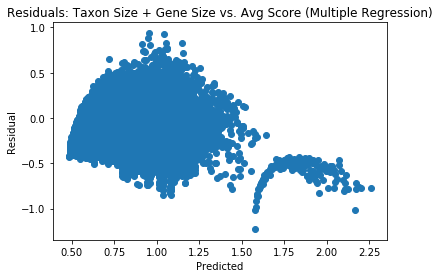

In [13]:
residuals = compute_residuals(ols_results_gene_taxon_avgScores, gene_taxon_avg_scores)
predicted = ols_results_gene_taxon_avgScores.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Taxon Size + Gene Size vs. Avg Score (Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

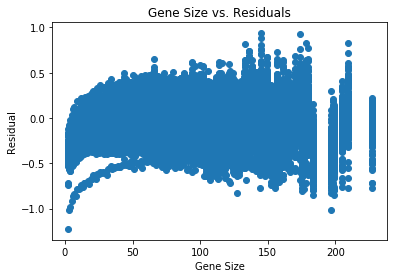

In [14]:
plt.scatter(np.array(gene_taxon_avg_scores['gene']), np.array(residuals))
plt.title('Gene Size vs. Residuals')
plt.xlabel('Gene Size')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

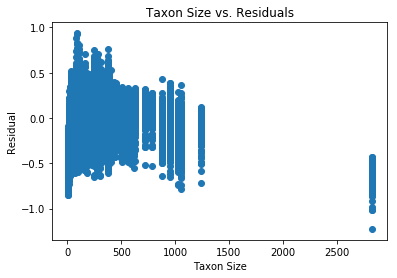

In [15]:
plt.scatter(np.array(gene_taxon_avg_scores['taxon']), np.array(residuals))
plt.title('Taxon Size vs. Residuals')
plt.xlabel('Taxon Size')
plt.ylabel('Residual')

## OLS on log gene profile size, log taxon profile size, average scores.

In [16]:
ols_results_geneLog_taxonLog_avgScores = ols_multiple_regression(geneLog_taxonLog_avg_scores, True, True, False,
                                                            False, False, False)
print(ols_results_geneLog_taxonLog_avgScores.params)
print(ols_results_geneLog_taxonLog_avgScores.summary())

Intercept   -0.600670
taxonLog     0.130627
geneLog      0.194204
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             avg_scores   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                 4.591e+04
Date:                Wed, 05 Sep 2018   Prob (F-statistic):               0.00
Time:                        13:11:20   Log-Likelihood:                 17435.
No. Observations:               32683   AIC:                        -3.486e+04
Df Residuals:                   32680   BIC:                        -3.484e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

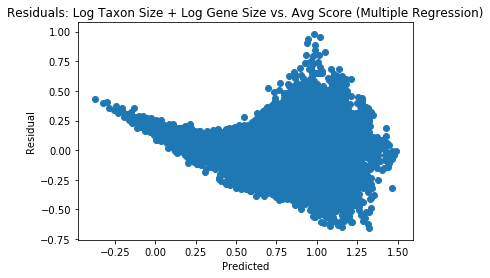

In [17]:
residuals = compute_residuals(ols_results_geneLog_taxonLog_avgScores, geneLog_taxonLog_avg_scores)
predicted = ols_results_geneLog_taxonLog_avgScores.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Log Taxon Size + Log Gene Size vs. Avg Score (Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

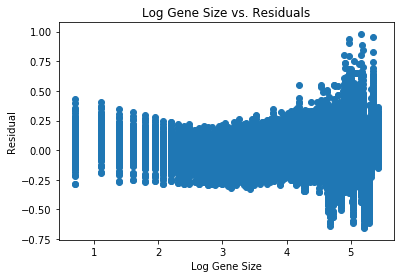

In [18]:
plt.scatter(np.array(geneLog_taxonLog_avg_scores['geneLog']), np.array(residuals))
plt.title('Log Gene Size vs. Residuals')
plt.xlabel('Log Gene Size')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

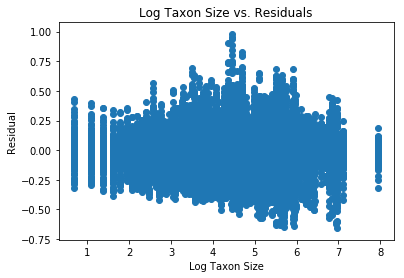

In [19]:
plt.scatter(np.array(geneLog_taxonLog_avg_scores['taxonLog']), np.array(residuals))
plt.title('Log Taxon Size vs. Residuals')
plt.xlabel('Log Taxon Size')
plt.ylabel('Residual')

## OLS on log gene profile size, log taxon profile size, log average scores.

In [20]:
ols_results_geneLog_taxonLog_avgScoresLog = ols_multiple_regression(geneLog_taxonLog_avg_scoresLog, True, True, True,
                                                               False, False, False)
print(ols_results_geneLog_taxonLog_avgScoresLog.params)
print(ols_results_geneLog_taxonLog_avgScoresLog.summary())

Intercept   -2.376665
taxonLog     0.187863
geneLog      0.295250
dtype: float64
                            OLS Regression Results                            
Dep. Variable:          avg_scoresLog   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                 6.032e+04
Date:                Wed, 05 Sep 2018   Prob (F-statistic):               0.00
Time:                        13:11:21   Log-Likelihood:                 8984.1
No. Observations:               32683   AIC:                        -1.796e+04
Df Residuals:                   32680   BIC:                        -1.794e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

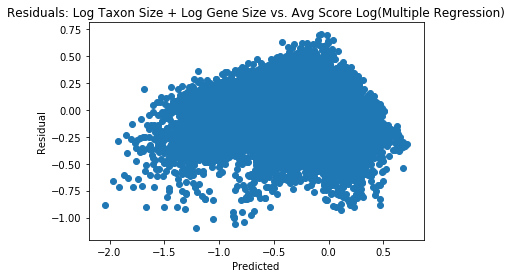

In [21]:
residuals = compute_residuals(ols_results_geneLog_taxonLog_avgScoresLog, geneLog_taxonLog_avg_scoresLog)
predicted = ols_results_geneLog_taxonLog_avgScoresLog.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Log Taxon Size + Log Gene Size vs. Avg Score Log(Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

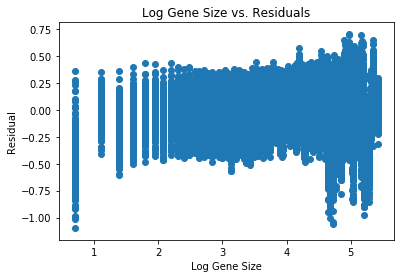

In [22]:
plt.scatter(np.array(geneLog_taxonLog_avg_scoresLog['geneLog']), np.array(residuals))
plt.title('Log Gene Size vs. Residuals')
plt.xlabel('Log Gene Size')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

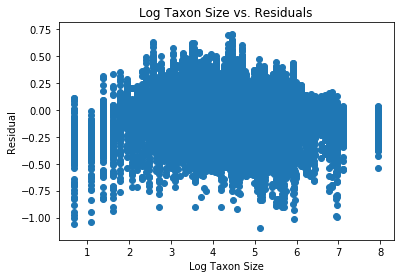

In [23]:
plt.scatter(np.array(geneLog_taxonLog_avg_scoresLog['taxonLog']), np.array(residuals))
plt.title('Log Taxon Size vs. Residuals')
plt.xlabel('Log Taxon Size')
plt.ylabel('Residual')

## OLS on box cox gene profile size, box cox taxon profile size, average scores.

In [24]:
ols_results_geneBoxCox_taxonBoxCox_avgScores = ols_multiple_regression(geneBoxCox_taxonBoxCox_avg_scores, 
                                                                   False, False, False, True, True, False)
print(ols_results_geneBoxCox_taxonBoxCox_avgScores.params)
print(ols_results_geneBoxCox_taxonBoxCox_avgScores.summary())

Intercept     -0.041755
taxonBoxCox    0.070701
geneBoxCox     0.019600
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             avg_scores   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                 3.803e+04
Date:                Wed, 05 Sep 2018   Prob (F-statistic):               0.00
Time:                        13:11:23   Log-Likelihood:                 15223.
No. Observations:               32683   AIC:                        -3.044e+04
Df Residuals:                   32680   BIC:                        -3.041e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

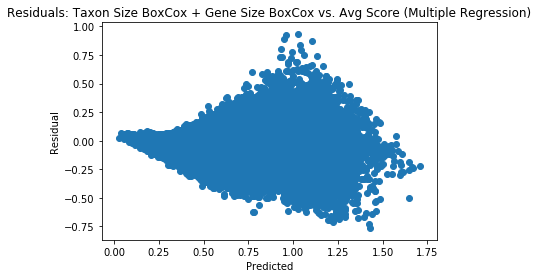

In [25]:
residuals = compute_residuals(ols_results_geneBoxCox_taxonBoxCox_avgScores, geneBoxCox_taxonBoxCox_avg_scores)
predicted = ols_results_geneBoxCox_taxonBoxCox_avgScores.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Taxon Size BoxCox + Gene Size BoxCox vs. Avg Score (Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

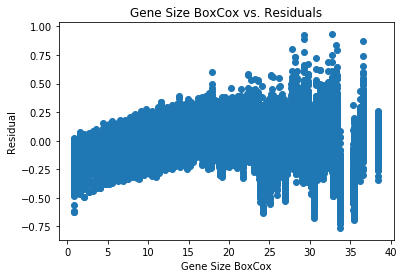

In [26]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_avg_scores['geneBoxCox']), np.array(residuals))
plt.title('Gene Size BoxCox vs. Residuals')
plt.xlabel('Gene Size BoxCox')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

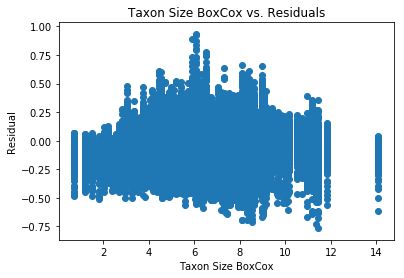

In [27]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_avg_scores['taxonBoxCox']), np.array(residuals))
plt.title('Taxon Size BoxCox vs. Residuals')
plt.xlabel('Taxon Size BoxCox')
plt.ylabel('Residual')

## OLS on box cox gene profile size, box cox taxon profile size, box cox average scores.

In [28]:
ols_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox = ols_multiple_regression(geneBoxCox_taxonBoxCox_avg_scoresBoxCox, 
                                                                   False, False, False, True, True, True)
print(ols_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox.params)
print(ols_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox.summary())

Intercept     -1.071224
taxonBoxCox    0.072568
geneBoxCox     0.020133
dtype: float64
                            OLS Regression Results                            
Dep. Variable:       avg_scoresBoxCox   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                 3.852e+04
Date:                Wed, 05 Sep 2018   Prob (F-statistic):               0.00
Time:                        13:11:24   Log-Likelihood:                 14570.
No. Observations:               32683   AIC:                        -2.913e+04
Df Residuals:                   32680   BIC:                        -2.911e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

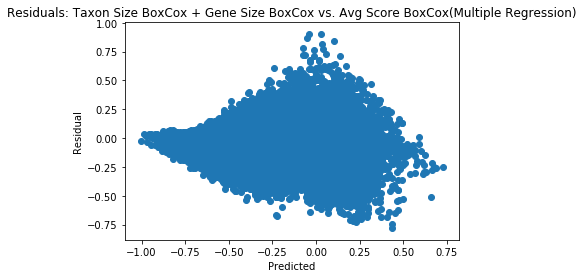

In [29]:
residuals = compute_residuals(ols_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox, geneBoxCox_taxonBoxCox_avg_scoresBoxCox)
predicted = ols_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Taxon Size BoxCox + Gene Size BoxCox vs. Avg Score BoxCox(Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

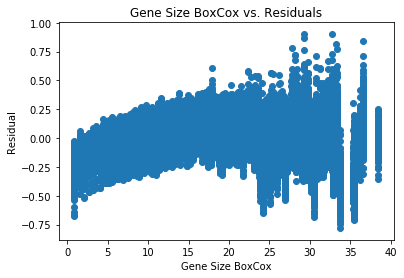

In [30]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_avg_scoresBoxCox['geneBoxCox']), np.array(residuals))
plt.title('Gene Size BoxCox vs. Residuals')
plt.xlabel('Gene Size BoxCox')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

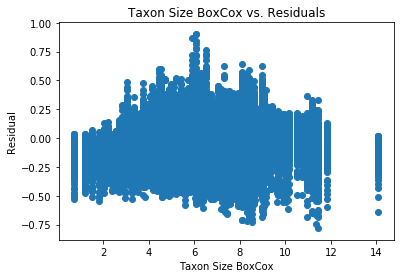

In [31]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_avg_scoresBoxCox['taxonBoxCox']), np.array(residuals))
plt.title('Taxon Size BoxCox vs. Residuals')
plt.xlabel('Taxon Size BoxCox')
plt.ylabel('Residual')

## WLS Multi Regression

For the weights of each data point we will use the number of times the pair (gene profile size, taxon profile size) appears in the data set. That should be relevant thowards how important that data point is for the overall data and modeling.

## Computing pair count (taxon, gene)-score

In [32]:
gene_taxon_pair_count = gene_taxon_scores.groupby(['taxon','gene']).size().reset_index(name='count')
print(gene_taxon_pair_count.head())

   taxon  gene  count
0      2     2  94521
1      2     3  99225
2      2     4  52577
3      2     5  42826
4      2     6  38710


In [33]:
def wls_multiple_regression(input_data):
    
    if input_data is None:
        return               
        
    y = input_data.iloc[:,2]
    X = input_data[input_data.columns[0:2]]
    X = sm.add_constant(X)
    results = smf.WLS(y, X, weights = gene_taxon_pair_count.loc[:,'count']).fit()
    return results    

## WLS on gene profile size, taxon profile size, average scores.

In [34]:
wls_results_gene_taxon_avgScores = wls_multiple_regression(gene_taxon_avg_scores)
print(wls_results_gene_taxon_avgScores.params)
print(wls_results_gene_taxon_avgScores.summary())

const    0.213585
taxon    0.000444
gene     0.005959
dtype: float64
                            WLS Regression Results                            
Dep. Variable:             avg_scores   R-squared:                       0.541
Model:                            WLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                 1.929e+04
Date:                Wed, 05 Sep 2018   Prob (F-statistic):               0.00
Time:                        13:11:26   Log-Likelihood:                -20656.
No. Observations:               32683   AIC:                         4.132e+04
Df Residuals:                   32680   BIC:                         4.134e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

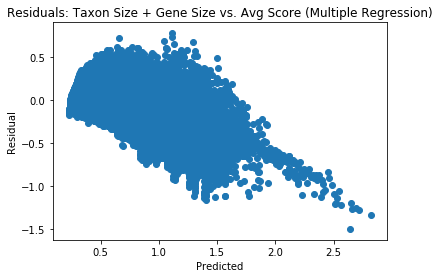

In [35]:
residuals = compute_residuals(wls_results_gene_taxon_avgScores, gene_taxon_avg_scores)
predicted = wls_results_gene_taxon_avgScores.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Taxon Size + Gene Size vs. Avg Score (Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

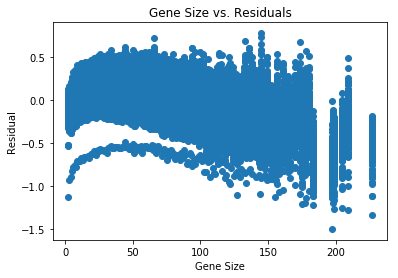

In [36]:
plt.scatter(np.array(gene_taxon_avg_scores['gene']), np.array(residuals))
plt.title('Gene Size vs. Residuals')
plt.xlabel('Gene Size')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

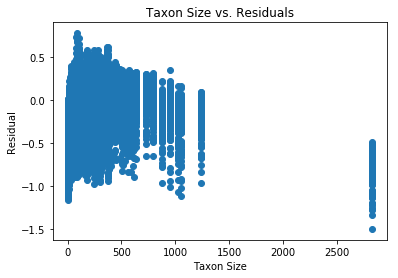

In [37]:
plt.scatter(np.array(gene_taxon_avg_scores['taxon']), np.array(residuals))
plt.title('Taxon Size vs. Residuals')
plt.xlabel('Taxon Size')
plt.ylabel('Residual')

## WLS on log gene profile size, log taxon profile size, average scores.

In [38]:
wls_results_geneLog_taxonLog_avgScores = wls_multiple_regression(geneLog_taxonLog_avg_scores)
print(wls_results_geneLog_taxonLog_avgScores.params)
print(wls_results_geneLog_taxonLog_avgScores.summary())

const      -0.204638
taxonLog    0.080568
geneLog     0.126666
dtype: float64
                            WLS Regression Results                            
Dep. Variable:             avg_scores   R-squared:                       0.856
Model:                            WLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                 9.716e+04
Date:                Wed, 05 Sep 2018   Prob (F-statistic):               0.00
Time:                        13:11:28   Log-Likelihood:                -1721.2
No. Observations:               32683   AIC:                             3448.
Df Residuals:                   32680   BIC:                             3474.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

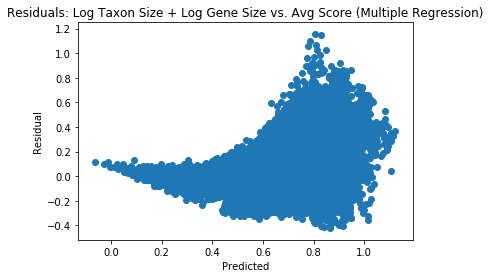

In [39]:
residuals = compute_residuals(wls_results_geneLog_taxonLog_avgScores, geneLog_taxonLog_avg_scores)
predicted = wls_results_geneLog_taxonLog_avgScores.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Log Taxon Size + Log Gene Size vs. Avg Score (Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

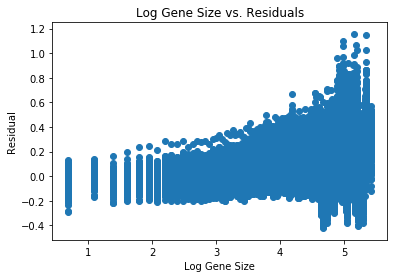

In [40]:
plt.scatter(np.array(geneLog_taxonLog_avg_scores['geneLog']), np.array(residuals))
plt.title('Log Gene Size vs. Residuals')
plt.xlabel('Log Gene Size')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

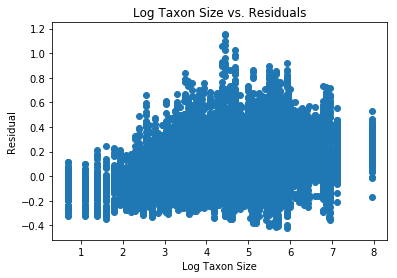

In [41]:
plt.scatter(np.array(geneLog_taxonLog_avg_scores['taxonLog']), np.array(residuals))
plt.title('Log Taxon Size vs. Residuals')
plt.xlabel('Log Taxon Size')
plt.ylabel('Residual')

## WLS on log gene profile size, log taxon profile size, log average scores.

In [42]:
wls_results_geneLog_taxonLog_avgScoresLog = wls_multiple_regression(geneLog_taxonLog_avg_scoresLog)
print(wls_results_geneLog_taxonLog_avgScoresLog.params)
print(wls_results_geneLog_taxonLog_avgScoresLog.summary())

const      -2.903170
taxonLog    0.252263
geneLog     0.378430
dtype: float64
                            WLS Regression Results                            
Dep. Variable:          avg_scoresLog   R-squared:                       0.891
Model:                            WLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                 1.333e+05
Date:                Wed, 05 Sep 2018   Prob (F-statistic):               0.00
Time:                        13:11:29   Log-Likelihood:                -33041.
No. Observations:               32683   AIC:                         6.609e+04
Df Residuals:                   32680   BIC:                         6.611e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

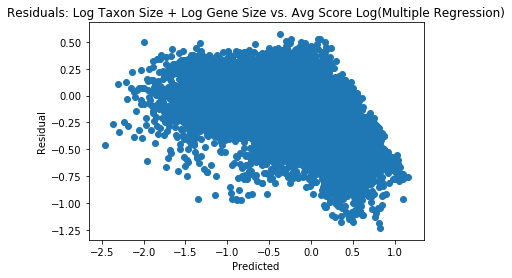

In [43]:
residuals = compute_residuals(wls_results_geneLog_taxonLog_avgScoresLog, geneLog_taxonLog_avg_scoresLog)
predicted = wls_results_geneLog_taxonLog_avgScoresLog.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Log Taxon Size + Log Gene Size vs. Avg Score Log(Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

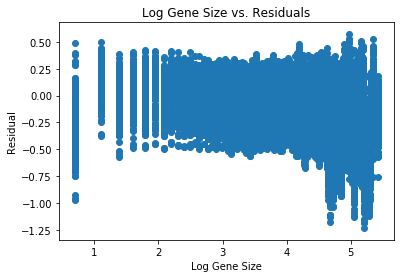

In [44]:
plt.scatter(np.array(geneLog_taxonLog_avg_scoresLog['geneLog']), np.array(residuals))
plt.title('Log Gene Size vs. Residuals')
plt.xlabel('Log Gene Size')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

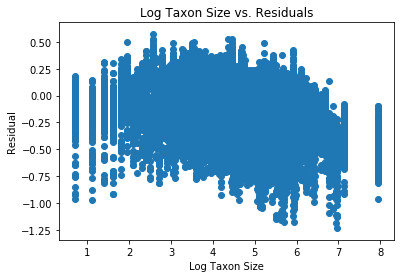

In [45]:
plt.scatter(np.array(geneLog_taxonLog_avg_scoresLog['taxonLog']), np.array(residuals))
plt.title('Log Taxon Size vs. Residuals')
plt.xlabel('Log Taxon Size')
plt.ylabel('Residual')

## WLS on box cox gene profile size, box cox taxon profile size, average scores.

In [46]:
wls_results_geneBoxCox_taxonBoxCox_avgScores = wls_multiple_regression(geneBoxCox_taxonBoxCox_avg_scores)
print(wls_results_geneBoxCox_taxonBoxCox_avgScores.params)
print(wls_results_geneBoxCox_taxonBoxCox_avgScores.summary())

const         -0.027637
taxonBoxCox    0.049842
geneBoxCox     0.026002
dtype: float64
                            WLS Regression Results                            
Dep. Variable:             avg_scores   R-squared:                       0.835
Model:                            WLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                 8.285e+04
Date:                Wed, 05 Sep 2018   Prob (F-statistic):               0.00
Time:                        13:11:31   Log-Likelihood:                -3924.3
No. Observations:               32683   AIC:                             7855.
Df Residuals:                   32680   BIC:                             7880.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

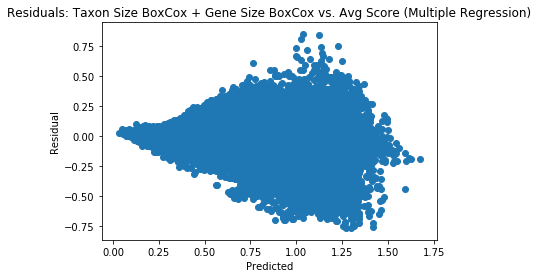

In [47]:
residuals = compute_residuals(wls_results_geneBoxCox_taxonBoxCox_avgScores, geneBoxCox_taxonBoxCox_avg_scores)
predicted = wls_results_geneBoxCox_taxonBoxCox_avgScores.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Taxon Size BoxCox + Gene Size BoxCox vs. Avg Score (Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

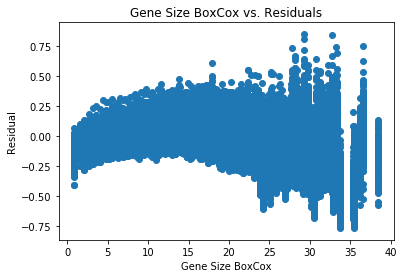

In [48]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_avg_scores['geneBoxCox']), np.array(residuals))
plt.title('Gene Size BoxCox vs. Residuals')
plt.xlabel('Gene Size BoxCox')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

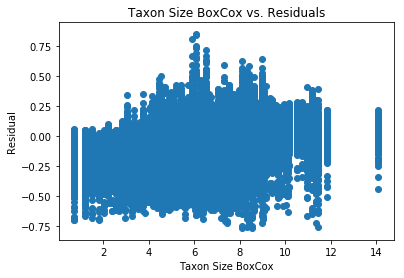

In [49]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_avg_scores['taxonBoxCox']), np.array(residuals))
plt.title('Taxon Size BoxCox vs. Residuals')
plt.xlabel('Taxon Size BoxCox')
plt.ylabel('Residual')

## WLS on box cox gene profile size, box cox taxon profile size, box cox average scores.

In [50]:
wls_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox = wls_multiple_regression(geneBoxCox_taxonBoxCox_avg_scoresBoxCox)
print(wls_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox.params)
print(wls_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox.summary())

const         -1.095874
taxonBoxCox    0.054757
geneBoxCox     0.028268
dtype: float64
                            WLS Regression Results                            
Dep. Variable:       avg_scoresBoxCox   R-squared:                       0.838
Model:                            WLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                 8.476e+04
Date:                Wed, 05 Sep 2018   Prob (F-statistic):               0.00
Time:                        13:11:32   Log-Likelihood:                -6442.9
No. Observations:               32683   AIC:                         1.289e+04
Df Residuals:                   32680   BIC:                         1.292e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

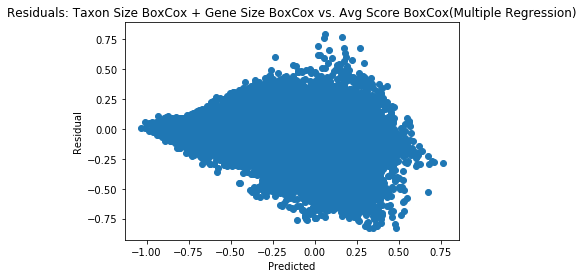

In [51]:
residuals = compute_residuals(wls_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox, geneBoxCox_taxonBoxCox_avg_scoresBoxCox)
predicted = wls_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Taxon Size BoxCox + Gene Size BoxCox vs. Avg Score BoxCox(Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

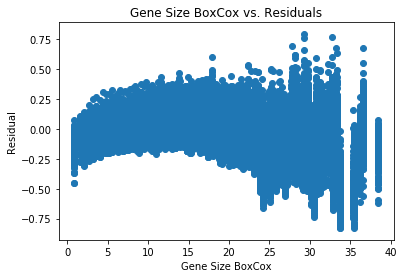

In [52]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_avg_scoresBoxCox['geneBoxCox']), np.array(residuals))
plt.title('Gene Size BoxCox vs. Residuals')
plt.xlabel('Gene Size BoxCox')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

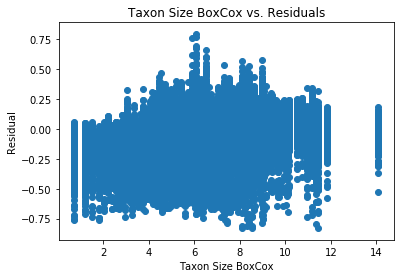

In [53]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_avg_scoresBoxCox['taxonBoxCox']), np.array(residuals))
plt.title('Taxon Size BoxCox vs. Residuals')
plt.xlabel('Taxon Size BoxCox')
plt.ylabel('Residual')